In [50]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import KFold, train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.preprocessing import StandardScaler
from ucimlrepo import fetch_ucirepo

rice_cammeo_and_osmancik = fetch_ucirepo(id=545) 
parkinsons = fetch_ucirepo(id=174) 
cdc_diabetes_health_indicators = fetch_ucirepo(id=891)


splits = [(0.2, 0.8), (0.5, 0.5), (0.8, 0.2)]
n_estimators = 1024
max_features_options = [1, 2, 4, 8, 12, 16, 20]

In [51]:
def kfold(X_train, y_train, rand_state):
    kf = KFold(n_splits=5, shuffle=True, random_state=rand_state)
    opt_features = None
    best_score = 0

    for max_features in max_features_options:
        scores = []
        for train_idx, val_idx in kf.split(X_train):
            X_tr, X_val = X_train.iloc[train_idx], X_train.iloc[val_idx]
            y_tr, y_val = y_train.iloc[train_idx], y_train.iloc[val_idx]

            rf = RandomForestClassifier(n_estimators=n_estimators, max_features=max_features, random_state=rand_state)
            rf.fit(X_tr, y_tr)
            scores.append(accuracy_score(y_val, rf.predict(X_val)))

        avg_score = np.mean(scores)
        if avg_score > best_score:
            best_score = avg_score
            opt_features = max_features

    return opt_features, best_score



In [55]:
def eval_split(X, y, train_size, test_size, rand_state):
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, train_size =train_size, test_size=test_size, random_state=rand_state)

    scaler = StandardScaler()
    X_train = pd.DataFrame(scaler.fit_transform(X_train), columns=X.columns)
    X_test = pd.DataFrame(scaler.transform(X_test), columns=X.columns)

    
    opt_features, best_cv_score = kfold(X_train, y_train, rand_state)
    print(f"  Optimal Features: {opt_features}, CV Accuracy: {best_cv_score:.4f}")

    rf = RandomForestClassifier(n_estimators=n_estimators, max_features=opt_features, random_state=rand_state)
    rf.fit(X_train, y_train)

    y_pred = rf.predict(X_test)
    test_accuracy = accuracy_score(y_test, y_pred)
    print(f"Test Accuracy: {test_accuracy:.4f}")

    conf_matrix = confusion_matrix(y_test, y_pred)

    return test_accuracy, conf_matrix

## Dataset 1: Diabetes

---------- Partition: Train Size: 20.0% Test Size: 80.0%----------
Trial 1:
  Optimal Features: 4, CV Accuracy: 0.8622
Test Accuracy: 0.8619
Trial 2:
  Optimal Features: 2, CV Accuracy: 0.8622
Test Accuracy: 0.8615
Trial 3:
  Optimal Features: 2, CV Accuracy: 0.8610
Test Accuracy: 0.8621
---------- Partition: Train Size: 50.0% Test Size: 50.0%----------
Trial 1:
  Optimal Features: 2, CV Accuracy: 0.8606
Test Accuracy: 0.8610
Trial 2:
  Optimal Features: 2, CV Accuracy: 0.8637
Test Accuracy: 0.8593
Trial 3:
  Optimal Features: 2, CV Accuracy: 0.8620
Test Accuracy: 0.8600
---------- Partition: Train Size: 80.0% Test Size: 20.0%----------
Trial 1:
  Optimal Features: 4, CV Accuracy: 0.8611
Test Accuracy: 0.8595
Trial 2:
  Optimal Features: 4, CV Accuracy: 0.8609
Test Accuracy: 0.8619
Trial 3:
  Optimal Features: 2, CV Accuracy: 0.8615
Test Accuracy: 0.8583

Summary of Test Accuracies:
  Partition Trial 1 20.0% /80.0%: Test Accuracy = 0.8619
  Partition Trial 2 20.0% /80.0%: Test Accuracy

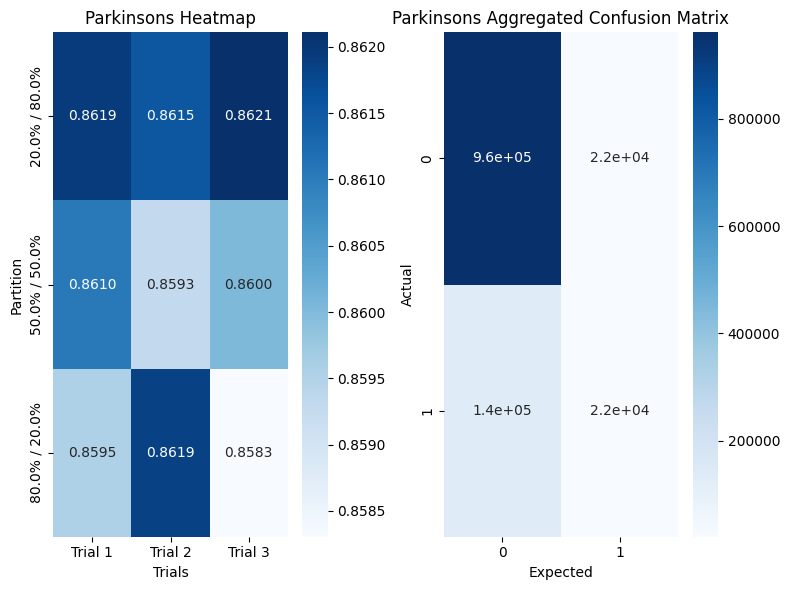

In [ ]:
X= cdc_diabetes_health_indicators.data.features
y = cdc_diabetes_health_indicators.data.targets

y = y.iloc[:, -1]
results = {}
acc_matrix =[]
agg_conf_matrix = np.zeros((2,2))
state = 42
for train_size, test_size in splits:
    trial_acc = []
    print(f"---------- Partition: Train Size: {train_size*100}% Test Size: {test_size*100}%----------")
    for i in range(3):
        print(f"Trial {i + 1}:")
        test_accuracy, conf_matrix = eval_split(X, y, train_size, test_size, rand_state=state)
        agg_conf_matrix += conf_matrix
        trial_acc.append(test_accuracy)
        results[f"Trial {i + 1} {train_size*100}% /{test_size*100:}%"] = test_accuracy
        state += 1
    acc_matrix.append(trial_acc)

df = pd.DataFrame(acc_matrix, columns=[f"Trial {i+1}" for i in range(3)], 
                        index=[f"{train_size*100}% / {test_size*100}%" for train_size, test_size in splits])


print("\nSummary of Test Accuracies:")

avg_acc = 0
for partition, accuracy in results.items():
    print(f"  Partition {partition}: Test Accuracy = {accuracy:.4f}")
    avg_acc += accuracy
avg_acc /= len(results)

print(f"Average Accuracy =  {avg_acc:.4f}")

plt.figure(figsize=(8, 6))

plt.subplot(2, 2, 1)
sns.heatmap(df, annot=True, cmap='Blues', fmt = '.4f')
# I forgot to edit plot titles, and this one took 9 hours to run, so I changed it here but haven't run it again since.
plt.title("Diabetes Heatmap")
plt.xlabel("Trials")
plt.ylabel("Partition")

plt.subplot(2, 2, 2)
sns.heatmap(agg_conf_matrix, annot=True, cmap='Blues', fmt='.0f')
plt.title("Diabetes Aggregated Confusion Matrix")
plt.xlabel("Expected")
plt.ylabel("Actual")

plt.tight_layout()

plt.show()

## Dataset 2: Parkinsons

---------- Partition: Train Size: 20.0% Test Size: 80.0%----------
Trial 1:
  Optimal Features: 1, CV Accuracy: 0.8643
Test Accuracy: 0.8397
Trial 2:
  Optimal Features: 20, CV Accuracy: 0.8464
Test Accuracy: 0.8333
Trial 3:
  Optimal Features: 4, CV Accuracy: 0.8464
Test Accuracy: 0.8397
---------- Partition: Train Size: 50.0% Test Size: 50.0%----------
Trial 1:
  Optimal Features: 8, CV Accuracy: 0.8863
Test Accuracy: 0.8776
Trial 2:
  Optimal Features: 1, CV Accuracy: 0.8553
Test Accuracy: 0.8776
Trial 3:
  Optimal Features: 4, CV Accuracy: 0.8342
Test Accuracy: 0.9286
---------- Partition: Train Size: 80.0% Test Size: 20.0%----------
Trial 1:
  Optimal Features: 4, CV Accuracy: 0.9232
Test Accuracy: 0.8718
Trial 2:
  Optimal Features: 8, CV Accuracy: 0.8849
Test Accuracy: 0.8462
Trial 3:
  Optimal Features: 4, CV Accuracy: 0.8907
Test Accuracy: 0.9231

Summary of Test Accuracies:
  Partition Trial 1 20.0% /80.0%: Test Accuracy = 0.8397
  Partition Trial 2 20.0% /80.0%: Test Accurac

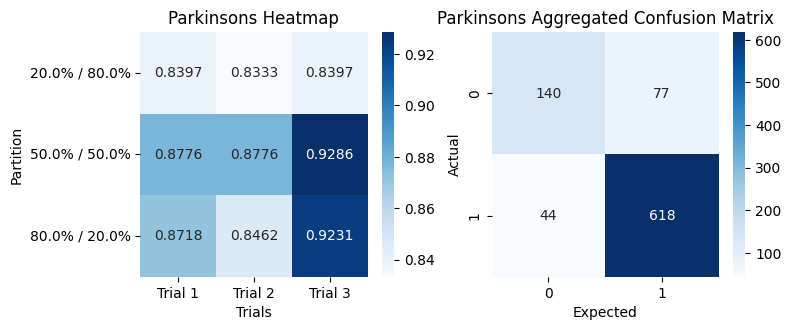

In [60]:
X= parkinsons.data.features
y = parkinsons.data.targets

y = y.iloc[:, -1]
results = {}
acc_matrix =[]
agg_conf_matrix = np.zeros((2,2))
state = 42
for train_size, test_size in splits:
    trial_acc = []
    print(f"---------- Partition: Train Size: {train_size*100}% Test Size: {test_size*100}%----------")
    for i in range(3):
        print(f"Trial {i + 1}:")
        test_accuracy, conf_matrix = eval_split(X, y, train_size, test_size, rand_state=state)
        agg_conf_matrix += conf_matrix
        trial_acc.append(test_accuracy)
        results[f"Trial {i + 1} {train_size*100}% /{test_size*100:}%"] = test_accuracy
        state += 1
    acc_matrix.append(trial_acc)

df = pd.DataFrame(acc_matrix, columns=[f"Trial {i+1}" for i in range(3)], 
                        index=[f"{train_size*100}% / {test_size*100}%" for train_size, test_size in splits])


print("\nSummary of Test Accuracies:")

avg_acc = 0
for partition, accuracy in results.items():
    print(f"  Partition {partition}: Test Accuracy = {accuracy:.4f}")
    avg_acc += accuracy
avg_acc /= len(results)

print(f"Average Accuracy =  {avg_acc:.4f}")

plt.figure(figsize=(8, 6))

plt.subplot(2, 2, 1)
sns.heatmap(df, annot=True, cmap='Blues', fmt = '.4f')
plt.title("Parkinsons Heatmap")
plt.xlabel("Trials")
plt.ylabel("Partition")

plt.subplot(2, 2, 2)
sns.heatmap(agg_conf_matrix, annot=True, cmap='Blues', fmt='.0f')
plt.title("Parkinsons Aggregated Confusion Matrix")
plt.xlabel("Expected")
plt.ylabel("Actual")

plt.tight_layout()

plt.show()

## Dataset 3: Rice (Cammeo and Osmancik)

In [ ]:
X= rice_cammeo_and_osmancik.data.features
y = rice_cammeo_and_osmancik.data.targets

y = y.iloc[:, -1]
results = {}
acc_matrix =[]
agg_conf_matrix = np.zeros((2,2))
state = 42
for train_size, test_size in splits:
    trial_acc = []
    print(f"---------- Partition: Train Size: {train_size*100}% Test Size: {test_size*100}%----------")
    for i in range(3):
        print(f"Trial {i + 1}:")
        test_accuracy, conf_matrix = eval_split(X, y, train_size, test_size, rand_state=state)
        agg_conf_matrix += conf_matrix
        trial_acc.append(test_accuracy)
        results[f"Trial {i + 1} {train_size*100}% /{test_size*100:}%"] = test_accuracy
        state += 1
    acc_matrix.append(trial_acc)

df = pd.DataFrame(acc_matrix, columns=[f"Trial {i+1}" for i in range(3)], 
                        index=[f"{train_size*100}% / {test_size*100}%" for train_size, test_size in splits])


print("\nSummary of Test Accuracies:")

avg_acc = 0
for partition, accuracy in results.items():
    print(f"  Partition {partition}: Test Accuracy = {accuracy:.4f}")
    avg_acc += accuracy
avg_acc /= len(results)

print(f"Average Accuracy =  {avg_acc:.4f}")

plt.figure(figsize=(8, 6))

plt.subplot(2, 2, 1)
sns.heatmap(df, annot=True, cmap='Blues', fmt = '.4f')
plt.title("Rice Heatmap")
plt.xlabel("Trials")
plt.ylabel("Partition")

plt.subplot(2, 2, 2)
sns.heatmap(agg_conf_matrix, annot=True, cmap='Blues', fmt='.0f')
plt.title("Rice Aggregated Confusion Matrix")
plt.xlabel("Expected")
plt.ylabel("Actual")

plt.tight_layout()

plt.show()

---------- Partition: Train Size: 20.0% Test Size: 80.0%----------
Trial 1:
  Optimal Features: 1, CV Accuracy: 0.9121
Test Accuracy: 0.9252
Trial 2:
  Optimal Features: 2, CV Accuracy: 0.9278
Test Accuracy: 0.9229
Trial 3:
  Optimal Features: 1, CV Accuracy: 0.9383
Test Accuracy: 0.9199
---------- Partition: Train Size: 50.0% Test Size: 50.0%----------
Trial 1:
  Optimal Features: 1, CV Accuracy: 0.9150
Test Accuracy: 0.9344
Trial 2:
  Optimal Features: 8, CV Accuracy: 0.9192
Test Accuracy: 0.9234
Trial 3:
  Optimal Features: 1, CV Accuracy: 0.9160
Test Accuracy: 0.9339
---------- Partition: Train Size: 80.0% Test Size: 20.0%----------
Trial 1:
